In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, arange, signal
plt.style.use('seaborn-poster')
%matplotlib inline

A thermometer in an office building measures the inside temperature every half hour for four months. Load the data and plot it. Convert the temperature to degrees Celsius. Measure time in weeks. The sample rate is thus 2 measurements/hour × 24 hours/day × 7 days/week = 336 measurements/week.

In [2]:
data = sio.loadmat('./data/officetemp.mat')

In [3]:
# convert to numpy array
temp = np.array([x[0] for x in data['temp']])

# convert the temp to Celsius
tempC = (temp - 32.)*5./9.

tempNorm = tempC - np.mean(tempC)

In [4]:
# this is sampling rate
fs = 2*24*7

# create timestamp
t = arange(len(temp))/float(fs)

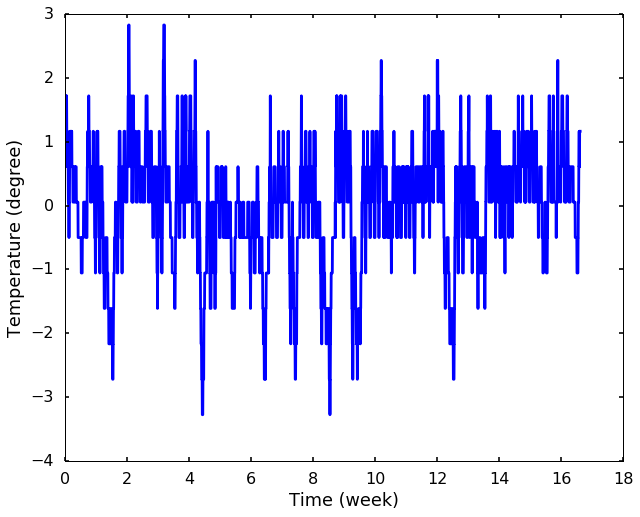

In [5]:
plt.figure(figsize = (10, 8))
plt.plot(t, tempNorm)
plt.xlabel('Time (week)')
plt.ylabel('Temperature (degree)')

### Zero crossings

In [6]:
from matplotlib.mlab import find
def freq_from_crossings(sig, fs):
    """
    Estimate frequency by counting zero crossings
    """
    # Find all indices right before a rising-edge zero crossing
    indices = find((sig[1:] >= 0) & (sig[:-1] < 0))

    # Naive (Measures 1000.185 Hz for 1000 Hz, for instance)
    # crossings = indices

    # More accurate, using linear interpolation to find intersample
    # zero-crossings (Measures 1000.000129 Hz for 1000 Hz, for instance)
    crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]

    # Some other interpolation based on neighboring points might be better.
    # Spline, cubic, whatever

    return fs / np.mean(np.diff(crossings))

In [7]:
freq_from_crossings(tempNorm, fs)

4.9313281391556449

### Frequency content

In [9]:
f, Pxx = signal.periodogram(tempNorm, fs = fs, window='cosine', scaling='spectrum')

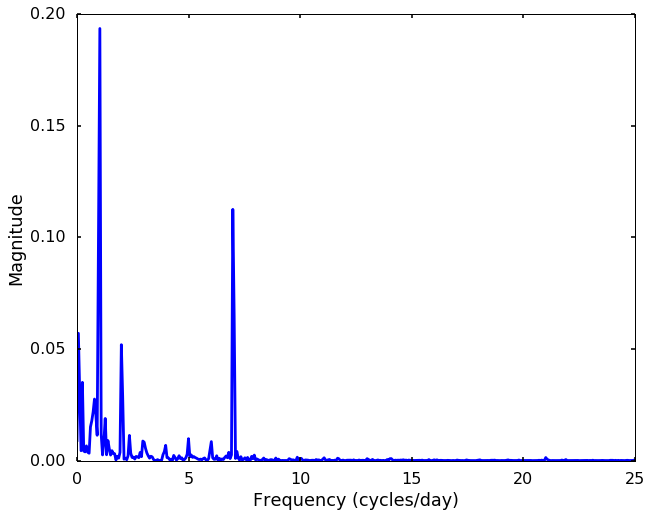

In [10]:
plt.figure(figsize = (10, 8))
plt.plot(f, Pxx)
plt.xlim(0, 25)
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Magnitude')

### Autocorrelation

There are three take-home messages from the above: 1. the autocorrelation, A, has larger value when like elements are lined up and multiplied, here at every other step. 2. The index of the autocorrelation corresponds to the relative shift. 3. When doing the autocorrelation over the full arrays, as shown here, there's always a downward ramp since the number of points added together to produce the value are reduced at each successive shift.

In [37]:
from statsmodels import api as sm

In [38]:
acf = sm.tsa.acf(tempNorm, nlags=3*7*fs)

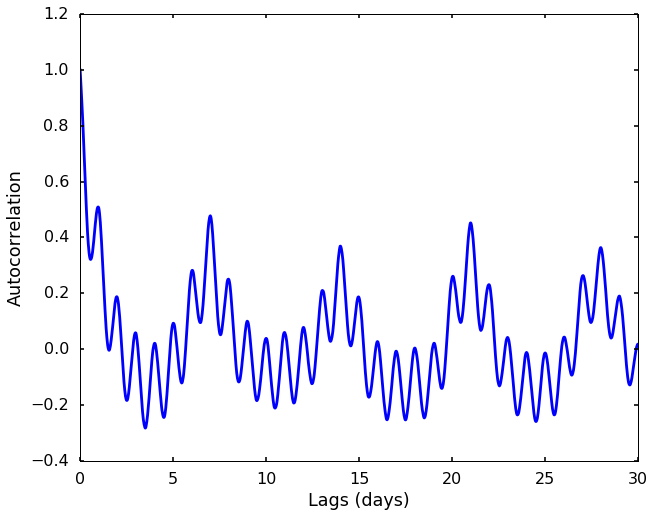

In [39]:
plt.figure(figsize = (10, 8))
lag = arange(len(tempNorm)) / 2. / 24.
plt.plot(lag, acf)
plt.xlim((0, 30))
plt.xlabel('Lags (days)')
plt.ylabel('Autocorrelation')

###  Lomb-Scargle periodogram 

In [11]:
A = 2.
w = 1.
phi = 0.5 * np.pi
nin = 1000
nout = 100000
frac_points = 0.9 # Fraction of points to select

In [12]:
r = np.random.rand(nin)
x = np.linspace(0.01, 10*np.pi, nin)
x = x[r >= frac_points]
normval = x.shape[0] # For normalization of the periodogram

In [13]:
y = A * np.sin(w*x+phi)

In [14]:
f = np.linspace(0.01, 10, nout)

In [18]:
pgram = signal.lombscargle(x, y, f)

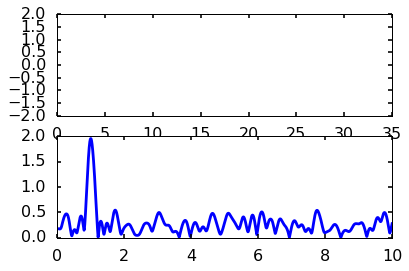

In [20]:
plt.subplot(2, 1, 1)
plt.plot(x, y, 'b+')
plt.subplot(2, 1, 2)

plt.plot(f, np.sqrt(4*(pgram/normval)))

plt.show()

### References

https://www.mathworks.com/examples/signal/mw/signal-ex69123038-find-periodicity-using-autocorrelation
https://www.mathworks.com/examples/signal/mw/signal-ex50284156-find-periodicity-using-frequency-analysis